In [1]:
%run init_notebook.py

In [2]:
from statsmodels.regression.linear_model import OLS

import matplotlib.lines as mlines

import pymc as pm
from patsy import dmatrix

import statsmodels.api as sm
import arviz as az

In [45]:
from src.utils import get_dt_index, load_pd_df, save_pd_df, pd_join_freq
from src.processing import *

In [46]:
# load data

In [55]:
hhp = load_pd_df('hhp.feather')

In [56]:
# exclude extreme values

In [57]:
cols = ['pi_exp', 'i_exp', 'pi_perc']

f = ((hhp[cols] <= 12) & (hhp[cols] > -2)).values
filt = f.copy().astype(float)
filt[~f] = np.ones((~f).sum()) * np.nan
hhp[cols] = hhp[cols] * filt

hhp[cols] = hhp[cols] / 100
hhp = hhp.reset_index(drop=True)

In [58]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
inlf = infl.drop(['cpi_DE', 'cpi_FR', 'is_train'], axis=1)

# merge

In [59]:
perc = load_pd_df('hhp_perc.feather')
exp = load_pd_df('hhp_exp.feather')
iexp = load_pd_df('hhp_iexp.feather')

In [60]:
hhp = pd_join_freq(hhp.set_index('date_recorded'), perc, "W", how='left').reset_index(drop=True).drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_forecast'), exp, "W", how='left').reset_index(drop=True).drop('index_right', axis=1)
hhp = pd_join_freq(hhp.set_index('date_forecast'), iexp, "W", how='left').reset_index(drop=True)

In [62]:
hhp['pi_exp_delta_MY'] = hhp['pi_exp_MY'] - hhp['pi_perc_MY']
hhp['pi_exp_delta_WY'] = hhp['pi_exp_WY'] - hhp['pi_perc_WY']

In [63]:
save_pd_df(hhp, 'hhp_processed.feather')

# model median

In [16]:
def get_gp_smoothing(y: np.array):
    X = np.linspace(0, 2, len(y))[:, None]

    with pm.Model() as gp_mod:
        ell = pm.Gamma("ell", alpha=2, beta=1)
        eta = pm.HalfNormal("eta", sigma=5)

        cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
        gp = pm.gp.Latent(cov_func=cov)

        f = gp.prior("f", X=X)

        sigma = pm.HalfNormal("sigma", sigma=2.0)
        nu = 1 + pm.Gamma(
            "nu", alpha=2, beta=0.1
        )  # add one because student t is undefined for degrees of freedom less than one
        obs = pm.Deterministic('obs', nu)
        y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

        prior = pm.sample_prior_predictive()
        trace = pm.sample(1000, nuts_sampler="numpyro", tune=1000, chains=2)
        post = pm.sample_posterior_predictive(trace)
        
    return gp_mod, prior, trace, post

## i exp

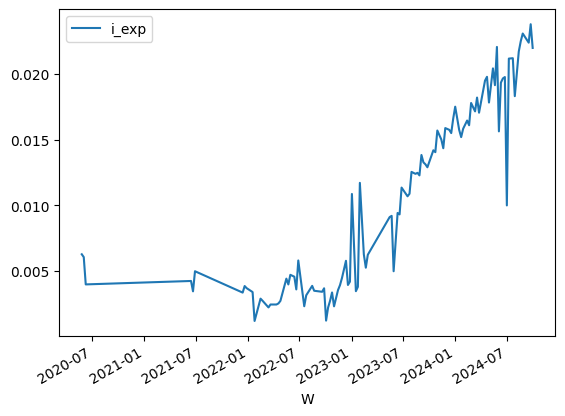

In [22]:
ser = pd_groupby(hhp.set_index('date_forecast'), ['i_exp'], 'W', 'mean').dropna()
ser.plot()
y = ser.values.ravel()

In [24]:
mod_i_exp, prior_i_epx, trace_i_exp, post_i_exp = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:08.109189
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:43:54.633010
Transforming variables...
Transformation time =  0:00:05.450138


Sampling: [y]


''

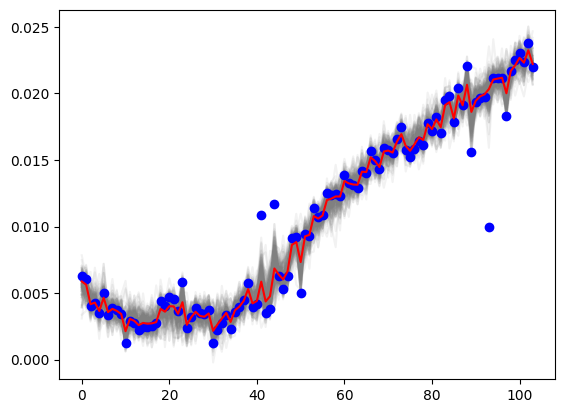

In [27]:
plt.plot(
    # trace_exp.posterior['y'][:, get_samp(1_000, 20)].values.reshape(2*20,y.shape[0]).T,
    trace_i_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T,
    color='grey', alpha=.1
)
plt.plot(y, linewidth=0, marker='o', color='blue')
plt.plot(trace_i_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
;

In [42]:
iexp = pd.DataFrame(
        data=trace_i_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['i_exp_WY']
    )

## pi exp

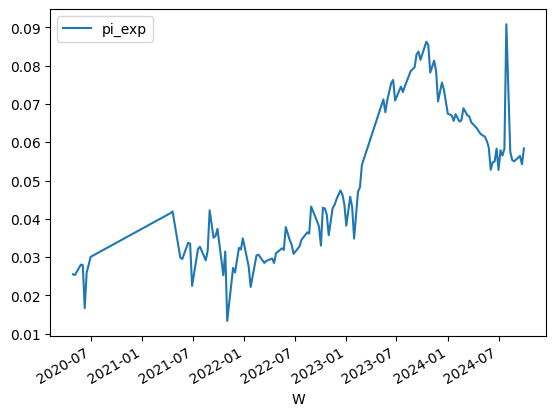

In [17]:
ser = pd_groupby(hhp.set_index('date_forecast'), ['pi_exp'], 'W', 'mean')
ser.plot()
y = ser.values.ravel()

In [12]:
mod_exp, prior_epx, trace_exp, post_exp = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.544977
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:30:23.035864
Transforming variables...


Sampling: [y]


Transformation time =  0:00:02.517553


''

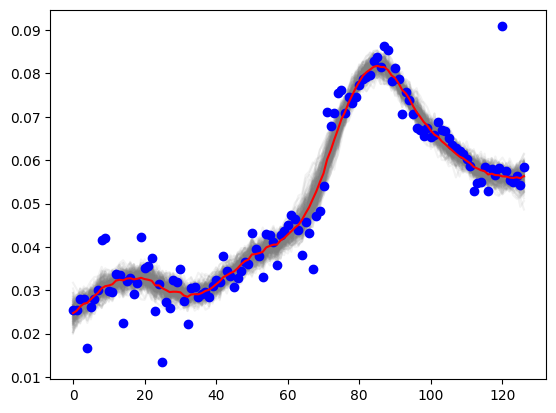

In [86]:
plt.plot(
    # trace_exp.posterior['y'][:, get_samp(1_000, 20)].values.reshape(2*20,y.shape[0]).T,
    trace_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T,
    color='grey', alpha=.1
)
plt.plot(y, linewidth=0, marker='o', color='blue')
plt.plot(trace_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
;

In [87]:
exp = pd.DataFrame(
        data=trace_exp.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['pi_exp_WY']
    )

## pi perc

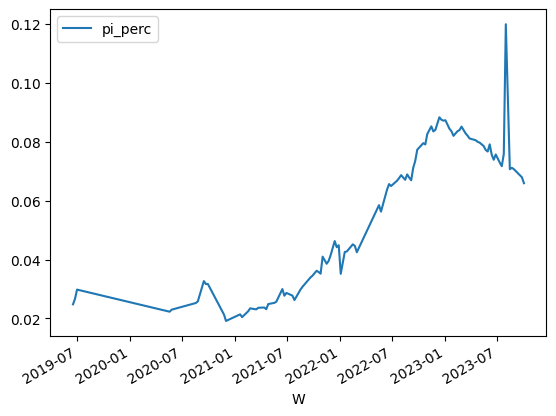

In [20]:
ser = pd_groupby(hhp.set_index('date_recorded'), ['pi_perc'], 'W', 'mean').dropna()
ser.plot()
y = ser.values[:, 0]

In [14]:
mod_perc, prior_perc, trace_perc, post_perc = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.812847
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:37:47.486008
Transforming variables...


Sampling: [y]


Transformation time =  0:00:01.844869


''

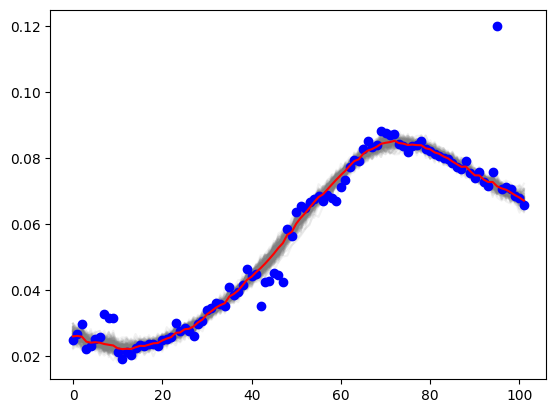

In [89]:
plt.plot(
    # trace_exp.posterior['y'][:, get_samp(1_000, 20)].values.reshape(2*20,y.shape[0]).T,
    trace_perc.posterior['f'][:, get_samp(1_000)].values.reshape(2*100, y.shape[0]).T,
    color='grey', alpha=.1
)
plt.plot(y, linewidth=0, marker='o', color='blue')
plt.plot(trace_perc.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0), color='red')
;

In [90]:
perc = pd.DataFrame(
        data=trace_perc.posterior['f'][:, get_samp(1_000)].values.reshape(2*100,y.shape[0]).mean(axis=0),
        index=ser.index,
        columns=['pi_perc_WY']
    )

In [38]:
perc['pi_perc_WY_diff'] = perc.pi_perc_WY.diff()
exp['pi_exp_WY_diff'] = exp.pi_exp_WY.diff()
iexp['i_exp_WY_diff'] = iexp.i_exp_WY.diff()

In [39]:
perc.index.name = 'date_recorded'
exp.index.name = 'date_forecast'
iexp.index.name = 'date_forecast'

In [40]:
_ = pd_groupby(perc, ['pi_perc_WY'], 'M', 'last')
_.columns = ['pi_perc_MY']
_.index.name = 'date'
perc = pd_join_freq(perc, _, 'M').set_index('date_recorded')

In [41]:
_ = pd_groupby(exp, ['pi_exp_WY'], 'M', 'last')
_.columns = ['pi_exp_MY']
_.index.name = 'date'
exp = pd_join_freq(exp, _, 'M').set_index('date_forecast') # axis=1)

In [42]:
_ = pd_groupby(iexp, ['i_exp_WY'], 'M', 'last')
_.columns = ['i_exp_MY']
_.index.name = 'date'
iexp = pd_join_freq(iexp, _, 'M').set_index('date_forecast') # axis=1)

In [44]:
save_pd_df(perc, 'hhp_perc.feather')
save_pd_df(exp, 'hhp_exp.feather')
save_pd_df(iexp, 'hhp_iexp.feather')